In [ ]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

#from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load Dataset

In [ ]:
df = pd.read_excel("./MODEL_TEST_SAMPLE.xlsx")
df.head()

,SEQ,AGE,GENDER,CONSTELLATION,MAX_TXN_DAY,AVG_TXN_M_DAY,AVG_TXN_M_C,AVG_TXN_D_C,AVG_DTRADE_M_DAY,AVG_DTRADE_M_C,AVG_DTRADE_D_C,DRAW,AVG_D_AUM,CREDIT_IND
0,1,49,0,2,161,12.50,23.25,1.86,3.0,4.0,1.33,1,110,1
1,2,55,1,10,218,2.50,6.00,2.40,0.0,0.0,0.00,0,13,1
2,3,24,0,4,186,4.36,6.09,1.40,0.0,0.0,0.00,0,28,1
3,4,46,0,4,161,3.43,66.57,19.42,0.0,0.0,0.00,0,49,1
4,5,29,0,11,165,4.00,6.08,1.52,0.0,0.0,0.00,1,13,1


# Data Exploratory

Class 0: 2849
Class 1: 1357
Proportion: 2.1 : 1


Text(0.5, 0, 'CREDIT_IND')

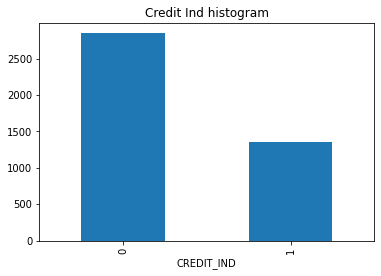

In [ ]:
# check imbalanced dataset
CREDIT_IND_count = df.CREDIT_IND.value_counts()
print('Class 0:', CREDIT_IND_count[0])
print('Class 1:', CREDIT_IND_count[1])
print('Proportion:', round(CREDIT_IND_count[0] / CREDIT_IND_count[1], 2), ': 1')

# CREDIT_IND histogram
CREDIT_IND_count.plot(kind='bar')
plt.title("Credit Ind histogram")
plt.xlabel("CREDIT_IND")

In [ ]:
# check missing values
cols_with_missing = [col for col in df.columns
                     if df[col].isnull().any()]

cols_with_missing

[]

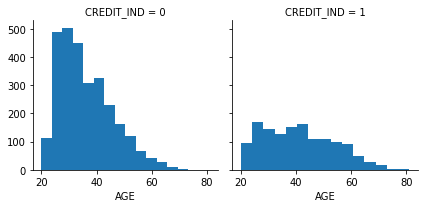

In [ ]:
g = sns.FacetGrid(df, col='CREDIT_IND')
g.map(plt.hist, 'AGE', bins=15)

In [ ]:
# Categorize 'AGE'
df.loc[ df['AGE'] <= 24, 'AGE'] = 0
df.loc[(df['AGE'] > 24) & (df['AGE'] <= 36), 'AGE'] = 1
df.loc[(df['AGE'] > 36) & (df['AGE'] <= 44), 'AGE'] = 2
df.loc[(df['AGE'] > 44) & (df['AGE'] <= 50), 'AGE'] = 3
df.loc[ df['AGE'] > 50, 'AGE'] = 4

df.head()

,SEQ,AGE,GENDER,CONSTELLATION,MAX_TXN_DAY,AVG_TXN_M_DAY,AVG_TXN_M_C,AVG_TXN_D_C,AVG_DTRADE_M_DAY,AVG_DTRADE_M_C,AVG_DTRADE_D_C,DRAW,AVG_D_AUM,CREDIT_IND
0,1,3,0,2,161,12.50,23.25,1.86,3.0,4.0,1.33,1,110,1
1,2,4,1,10,218,2.50,6.00,2.40,0.0,0.0,0.00,0,13,1
2,3,0,0,4,186,4.36,6.09,1.40,0.0,0.0,0.00,0,28,1
3,4,3,0,4,161,3.43,66.57,19.42,0.0,0.0,0.00,0,49,1
4,5,1,0,11,165,4.00,6.08,1.52,0.0,0.0,0.00,1,13,1


In [ ]:
# drop features: 'SEQ', 'GENDER', 'DRAW'
X = df.drop(['SEQ','CREDIT_IND','GENDER','DRAW'], axis=1)
y = df.CREDIT_IND

# Over-Sampling

In [ ]:
ros = RandomOverSampler(random_state=0)
ros.fit(X, y)
X_ros, y_ros = ros.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Train/Test Split

In [ ]:
# train_test_split 
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(
    X_ros, y_ros, test_size=0.3, random_state=42, shuffle=True)

# Training

In [ ]:
print('Start training...')

# build xgboost model
xgb_ros = XGBClassifier(
    learning_rate=0.3,
    n_estimators=50000,
    seed=2019, reg_alpha=5, eval_metric='auc')

xgb_ros.fit(
    X_train_ros, y_train_ros, 
    eval_set=[(X_test_ros, y_test_ros)],
    verbose=50,early_stopping_rounds=30)

print('')
print('-'*40)
print('Start predicting...')
# predict
y_pred_xgb_ros = xgb_ros.predict(X_test_ros)

# eval
print('')
print('Report :', classification_report(y_test_ros, y_pred_xgb_ros))
print('XGBoost Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test_ros, y_pred_xgb_ros)))
print('XGBoost Model AUC score: {0:0.4f}'.format(roc_auc_score(y_test_ros, y_pred_xgb_ros)))
print('XGBoost Model F1 score: {0:0.4f}'.format(f1_score(y_test_ros, y_pred_xgb_ros)))

Start training...
[0]	validation_0-auc:0.760004
Will train until validation_0-auc hasn't improved in 30 rounds.
[50]	validation_0-auc:0.823026
[100]	validation_0-auc:0.834575
[150]	validation_0-auc:0.840668
Stopping. Best iteration:
[140]	validation_0-auc:0.840732


----------------------------------------
Start predicting...

Report :               precision    recall  f1-score   support

           0       0.75      0.75      0.75       854
           1       0.75      0.76      0.75       856

    accuracy                           0.75      1710
   macro avg       0.75      0.75      0.75      1710
weighted avg       0.75      0.75      0.75      1710

XGBoost Model accuracy score: 0.7515
XGBoost Model AUC score: 0.7515
XGBoost Model F1 score: 0.7531


In [ ]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

cm_ros = confusion_matrix(y_test_ros, y_pred_xgb_ros)
print('XGBoost Confusion matrix\n\n', cm_ros)
print('\nTrue Positives(TP) = ', cm_ros[0,0])
print('\nTrue Negatives(TN) = ', cm_ros[1,1])
print('\nFalse Positives(FP) = ', cm_ros[0,1])
print('\nFalse Negatives(FN) = ', cm_ros[1,0])

XGBoost Confusion matrix

 [[637 217]
 [208 648]]

True Positives(TP) =  637

True Negatives(TN) =  648

False Positives(FP) =  217

False Negatives(FN) =  208


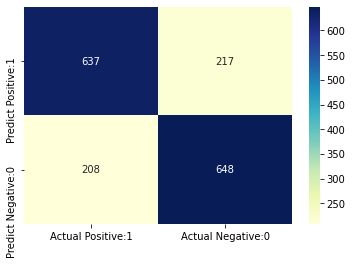

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix_ros = pd.DataFrame(data=cm_ros, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix_ros, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
print(classification_report(y_test_ros, y_pred_xgb_ros))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       854
           1       0.75      0.76      0.75       856

    accuracy                           0.75      1710
   macro avg       0.75      0.75      0.75      1710
weighted avg       0.75      0.75      0.75      1710



# Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "SVC" : SVC(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "XGBoost" : XGBClassifier()
}

In [ ]:
train_scores = []
test_scores = []

for key, classifier in classifiers.items():
    classifier.fit(X_train_ros, y_train_ros)
    train_score = classifier.score(X_train_ros, y_train_ros)
    train_scores.append(train_score)
    test_score = classifier.score(X_test_ros, y_test_ros)
    test_scores.append(test_score)

print(train_scores)
print(test_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[0.7086258776328987, 0.7973921765295887, 0.6599799398194583, 1.0, 1.0, 0.7733199598796389]
[0.6754385964912281, 0.7187134502923976, 0.656140350877193, 0.7970760233918128, 0.8497076023391813, 0.7292397660818714]


In [ ]:
rfc = RandomForestClassifier()
model = rfc.fit(X_train_ros, y_train_ros)
prediction = rfc.predict(X_test_ros)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_ros, prediction))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       854
           1       0.82      0.89      0.85       856

    accuracy                           0.85      1710
   macro avg       0.85      0.85      0.85      1710
weighted avg       0.85      0.85      0.85      1710



In [ ]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

cm_ros = confusion_matrix(y_test_ros, prediction)
print('Random Forest Classifier Confusion matrix\n\n', cm_ros)
print('\nTrue Positives(TP) = ', cm_ros[0,0])
print('\nTrue Negatives(TN) = ', cm_ros[1,1])
print('\nFalse Positives(FP) = ', cm_ros[0,1])
print('\nFalse Negatives(FN) = ', cm_ros[1,0])

Random Forest Classifier Confusion matrix

 [[685 169]
 [ 94 762]]

True Positives(TP) =  685

True Negatives(TN) =  762

False Positives(FP) =  169

False Negatives(FN) =  94


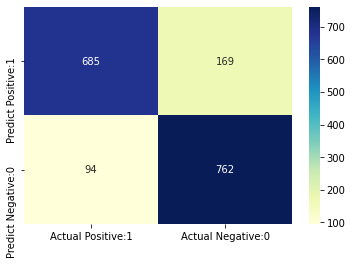

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix_ros = pd.DataFrame(data=cm_ros, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix_ros, annot=True, fmt='d', cmap='YlGnBu')

# Decision Tree Classifier

In [ ]:
clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                             max_features=None, max_leaf_nodes=None,
                             min_impurity_split=1e-07, min_samples_leaf=1, 
                             min_samples_split=2, min_weight_fraction_leaf=0.0,
                             presort=False, random_state=None, splitter='best')
model = clf.fit(X_train_ros, y_train_ros)
prediction = clf.predict(X_test_ros)

/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_ros, prediction))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       854
           1       0.72      0.69      0.70       856

    accuracy                           0.71      1710
   macro avg       0.71      0.71      0.71      1710
weighted avg       0.71      0.71      0.71      1710



In [ ]:
!pip install graphviz

In [ ]:
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=['AGE', 'CONSTELLATION', 'MAX_TXN_DAY', 'AVG_TXN_M_DAY', 'AVG_TXN_M_C', 'AVG_TXN_D_C', 'AVG_DTRADE_M_DAY', 'AVG_DTRADE_M_C', 'AVG_DTRADE_D_C', 'AVG_D_AUM'], 
                                class_names='CREDIT_IND', 
                                filled=True, rounded=True, 
                                special_characters=True) 

In [ ]:
import graphviz 
graph = graphviz.Source(dot_data) 
graph

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_ros, prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7082065705093129

## Max Depths

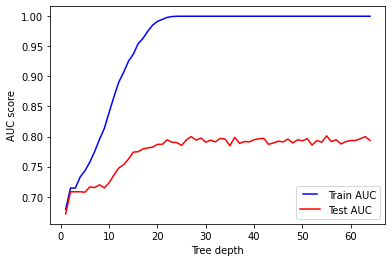

In [ ]:
max_depths = np.linspace(1, 64, 64, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train_ros, y_train_ros)
   train_pred = dt.predict(X_train_ros)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_ros, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test_ros)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_ros, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

## Min Samples Splits

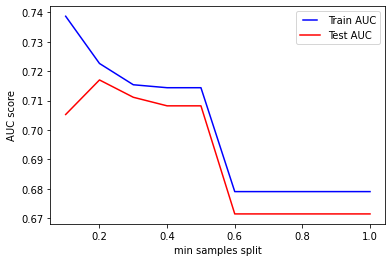

In [ ]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(X_train_ros, y_train_ros)
   train_pred = dt.predict(X_train_ros)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train_ros, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test_ros)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_ros, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

## Min Samples Leafs

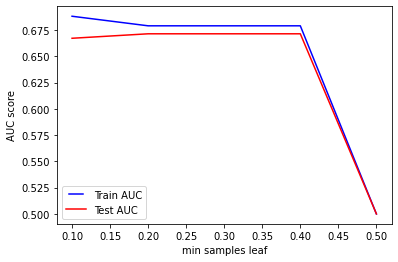

In [ ]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train_ros, y_train_ros)
   train_pred = dt.predict(X_train_ros)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_ros, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test_ros)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_ros, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

In [ ]:
clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                             max_features=7, max_leaf_nodes=None,
                             min_impurity_split=1e-07, min_samples_leaf=1, 
                             min_samples_split=2, min_weight_fraction_leaf=0.0,
                             presort=False, random_state=None, splitter='best')
model = clf.fit(X_train_ros, y_train_ros)
prediction = clf.predict(X_test_ros)

/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_ros, prediction))

              precision    recall  f1-score   support

           0       0.84      0.74      0.78       854
           1       0.77      0.86      0.81       856

    accuracy                           0.80      1710
   macro avg       0.80      0.80      0.80      1710
weighted avg       0.80      0.80      0.80      1710

